In [2]:
from tqdm import trange
import matplotlib.pyplot as plt

In [4]:
# load mnist dataset 
import numpy as np
import gzip
parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
X_train = parse("data/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = parse("data/train-labels-idx1-ubyte.gz")[8:]
X_test = parse("data/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = parse("data/t10k-labels-idx1-ubyte.gz")[8:]

5

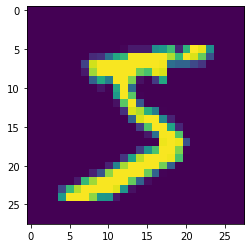

In [5]:
plt.imshow(X_train[0])
Y_train[0]

In [6]:
# network
import torch 
import torch.nn as nn
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.act = nn.ReLU()
    self.l2 = nn.Linear(128, 10, bias=False)
  def forward(self, x):
    x = self.l1(x)
    x = self.act(x)
    x = self.l2(x)
    return x

loss 0.17 accuracy 0.97: 100%|██████████| 1000/1000 [00:03<00:00, 309.36it/s]


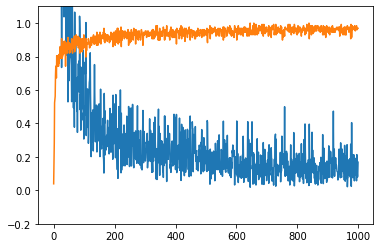

In [8]:
# training
BS = 128
model = Net()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=BS)
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss.backward()
  optimizer.step()
  losses.append(loss.detach().numpy())
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss.item(), accuracy))

plt.ylim(-.2, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [63]:
# evaluation
Y_test_preds_out = model(torch.tensor(X_test).reshape(-1, 28*28).float())
Y_test_preds = torch.argmax(Y_test_preds_out, dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9563

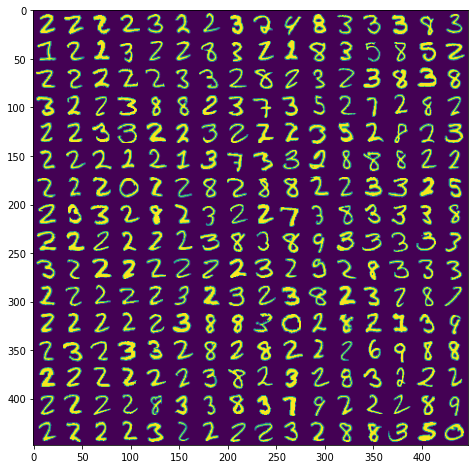

In [64]:
# uncertainty
Y_test_preds_out = Y_test_preds_out.detach().numpy()
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out)).sum(axis=1)
G = 16
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[0:G*G]
X_bad = X_test[[x[1] for x in grid]]
plt.figure(figsize=(8,8))
final = np.concatenate(X_bad.reshape((G, 28*G, 28)), axis=1)
plt.imshow(final)

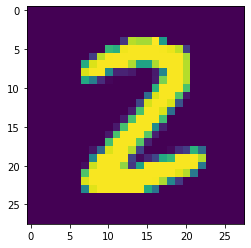

In [65]:
plt.imshow(X_test[np.argmax(ret)])